In [161]:
import numpy as np
import matplotlib.pyplot as plt

from fastprogress import progress_bar

import jlinops

# Deblurring with gradient regularization

In [162]:
# Parameters
# n = 100
# reg_lambda = 1e-3
# blur_sigma = 4

n = 100
reg_lambda = 1e0
blur_sigma = 4

# Setup
F = jlinops.Gaussian1DBlurOperator(n, blur_sigma=blur_sigma)
F = jlinops.black_box_to_dense(F)
R, W = jlinops.first_order_derivative_1d(n, boundary="zero")
R = R.toarray()
R = np.sqrt(reg_lambda)*R # add regularization effect

# Get spectrum of original problem
Q1 = (F.T @ F) + (R.T @ R)
Q1_eigvals = np.real(np.flip(np.sort(np.linalg.eigvals(Q1))))
Q1_cond = np.linalg.cond(Q1)

# Get spectrum for transformed problem
Rpinv = np.linalg.pinv(R)
Q2 = np.eye(R.shape[0]) + (Rpinv.T @ F.T @ F @ Rpinv)
Q2_eigvals = np.real(np.flip(np.sort(np.linalg.eigvals(Q2))))
Q2_cond = np.linalg.cond(Q2)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


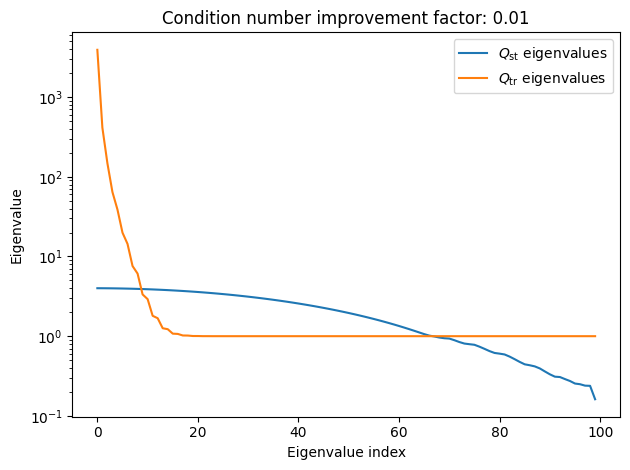

In [163]:
plt.semilogy(Q1_eigvals, label="$Q_{\\text{st}}$ eigenvalues")
plt.semilogy(Q2_eigvals, label="$Q_{\\text{tr}}$ eigenvalues")
plt.title(f"Condition number improvement factor: {Q1_cond/Q2_cond:.2f}")
plt.xlabel("Eigenvalue index")
plt.ylabel("Eigenvalue")
plt.legend()
plt.tight_layout()
plt.savefig("deblurring_gradient.png", dpi=250, bbox_inches="tight")
plt.savefig("deblurring_gradient.eps", bbox_inches="tight")
plt.show()

# Heatmap for varying blur sigma and regularization parameter

In [143]:
def get_rho(blur_sigma, reg_lambda):
    
    n = 100

    # Setup
    F = jlinops.Gaussian1DBlurOperator(n, blur_sigma=blur_sigma)
    F = jlinops.black_box_to_dense(F)
    R, W = jlinops.first_order_derivative_1d(n, boundary="zero")
    R = R.toarray()
    R = np.sqrt(reg_lambda)*R

    # Get spectrum of original problem
    Q1 = (F.T @ F) + (R.T @ R)
    Q1_eigvals = np.real(np.flip(np.sort(np.linalg.eigvals(Q1))))
    Q1_cond = np.linalg.cond(Q1)

    # Get spectrum for transformed problem
    Rpinv = np.linalg.pinv(R)
    Q2 = np.eye(R.shape[0]) + (Rpinv.T @ F.T @ F @ Rpinv)
    Q2_eigvals = np.real(np.flip(np.sort(np.linalg.eigvals(Q2))))
    Q2_cond = np.linalg.cond(Q2)

    # Improvement factor
    rho = Q1_cond/Q2_cond

    return rho
    
vget_rho = np.vectorize(get_rho)

In [396]:
def vget_rho(blur_sigmas, reg_lambdas):

    output_rhos = np.zeros_like(blur_sigmas)
    p, q = blur_sigmas.shape

    n = 100

    # Setup
    R, W = jlinops.first_order_derivative_1d(n, boundary="zero")
    _R = R.toarray()

    for i in progress_bar(range(p)):

        for j in range(q):

            blur_sigma = blur_sigmas[i,j]
            reg_lambda = reg_lambdas[i,j]
            R = np.sqrt(reg_lambda)*_R

            F = jlinops.Gaussian1DBlurOperator(n, blur_sigma=blur_sigma)
            F = jlinops.black_box_to_dense(F)

            # Get spectrum of original problem
            Q1 = (F.T @ F) + (R.T @ R)
            #Q1_eigvals = np.real(np.flip(np.sort(np.linalg.eigvals(Q1))))
            Q1_cond = np.linalg.cond(Q1)

            # Get spectrum for transformed problem
            Rpinv = np.linalg.pinv(R)
            Q2 = np.eye(R.shape[0]) + (Rpinv.T @ F.T @ F @ Rpinv)
            #Q2_eigvals = np.real(np.flip(np.sort(np.linalg.eigvals(Q2))))
            Q2_cond = np.linalg.cond(Q2)

            # Improvement factor
            rho = Q1_cond/Q2_cond


            output_rhos[i,j] = rho

            # print("finished one")
            

    return output_rhos

In [393]:
# Define the range and grid density for the parameters
x =  np.float64(np.arange(start=0, stop=80, step=1)) # blur
y =  np.logspace(-1, 3, num=20) # regularization parameter

# Create a meshgrid for the parameters
X, Y = np.meshgrid(x, y)

In [397]:
# Compute the function values
Z = vget_rho(X, Y)


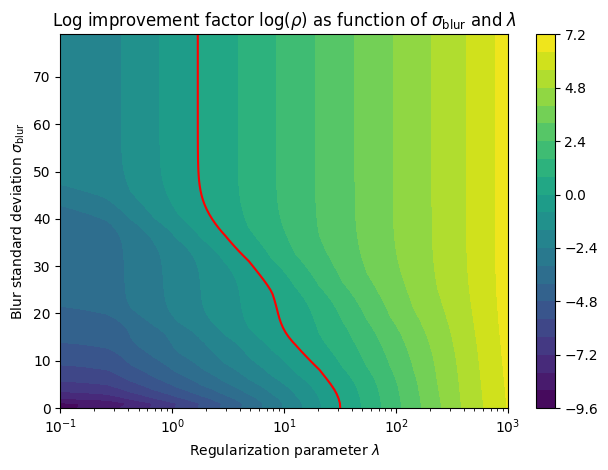

In [398]:
# Create the heatmap
plt.contourf(Y, X, np.log(Z), 20, cmap='viridis')
# Add a color bar to show the scale
plt.colorbar()

plt.contour(Y, X, Z, levels=[1.0], colors='red')



# Add labels and title if desired
plt.xlabel('Regularization parameter $\lambda$')
plt.ylabel('Blur standard deviation $\sigma_{\\text{blur}}$')
plt.title('Log improvement factor $\log(\\rho)$ as function of $\sigma_{\\text{blur}}$ and $\lambda$')
plt.xscale("log")
plt.tight_layout()
plt.savefig("deblurring_gradient_conditioning.png", dpi=250, bbox_inches="tight")
plt.savefig("deblurring_gradient_conditioning.eps", bbox_inches="tight")
# Show the plot
plt.show()

# Undersampling and gradient

# With sparsity

In [164]:
def rand_sparse_vector(n=50, num_nsparse=10, sparse_low=1e-4, sparse_high=1e-3, nsparse_low=1e-1, nsparse_high=1e1):
    """
    Generates a random vector of length n, where num_nsparse components are `non-sparse`. 
    The `sparse` and `non-sparse` components are drawn from uniform distributions as specified.
    """
    assert num_nsparse < n, "num_nsparse must be less than n."
    result = np.random.uniform(low=sparse_low, high=sparse_high, size=n)
    nsparse_idxs = np.random.choice( [i for i in range(n)], size=num_nsparse, replace=False )
    result[nsparse_idxs] = np.random.uniform(low=nsparse_low, high=nsparse_high, size=num_nsparse)
    return result

# Blurring and sparse signal

In [166]:
n = 100
knsparse = 5
blur_sigma = 4

# Setup
F = jlinops.Gaussian1DBlurOperator(n, blur_sigma=blur_sigma)
F = jlinops.black_box_to_dense(F)
R, W = jlinops.first_order_derivative_1d(n, boundary="zero")
R = R.toarray()

theta = rand_sparse_vector(n=n, num_nsparse=knsparse, sparse_low=1e-4, sparse_high=1e-3, nsparse_low=1e0, nsparse_high=1e1)

R = np.diag(1.0/np.sqrt(theta)) @ R # put in the weights 
Rpinv = np.linalg.pinv(R)


# Get spectrum of original problem
Q1 = (F.T @ F) + (R.T @ R)
Q1_eigvals = np.real(np.flip(np.sort(np.linalg.eigvals(Q1))))
Q1_cond = np.linalg.cond(Q1)

# Get spectrum for transformed problem
Rpinv = np.linalg.pinv(R)
Q2 = np.eye(R.shape[0]) + (Rpinv.T @ F.T @ F @ Rpinv)
Q2_eigvals = np.real(np.flip(np.sort(np.linalg.eigvals(Q2))))
Q2_cond = np.linalg.cond(Q2)

# Improvement factor
rho = Q1_cond/Q2_cond

print(rho)

67.12050865588377


### Look at the distribution of this

In [231]:
n = 100
knsparse = 99
blur_sigma = 4
n_samples = int(1e2)

# Setup
F = jlinops.Gaussian1DBlurOperator(n, blur_sigma=blur_sigma)
F = jlinops.black_box_to_dense(F)
R, W = jlinops.first_order_derivative_1d(n, boundary="zero")
_R = R.toarray()

rho_ests = []
Q1_conds = []
Q2_conds = []
for j in progress_bar(range(n_samples)):

    theta = rand_sparse_vector(n=n, num_nsparse=knsparse, sparse_low=1e-3, sparse_high=1e-2, nsparse_low=1e0, nsparse_high=1e1)

    R = np.diag(1.0/np.sqrt(theta)) @ _R # put in the weights 


    # Get spectrum of original problem
    Q1 = (F.T @ F) + (R.T @ R)
    Q1_eigvals = np.real(np.flip(np.sort(np.linalg.eigvals(Q1))))
    Q1_cond = np.linalg.cond(Q1)
    Q1_conds.append(Q1_cond)

    # Get spectrum for transformed problem
    Rpinv = np.linalg.pinv(R)
    Q2 = np.eye(R.shape[0]) + (Rpinv.T @ F.T @ F @ Rpinv)
    Q2_eigvals = np.real(np.flip(np.sort(np.linalg.eigvals(Q2))))
    Q2_cond = np.linalg.cond(Q2)
    Q2_conds.append(Q2_cond)

    # Improvement factor
    rho = Q1_cond/Q2_cond

    rho_ests.append(rho)

rho_ests = np.asarray(rho_ests)


In [233]:
(rho_ests > 1).sum()/n_samples

0.13

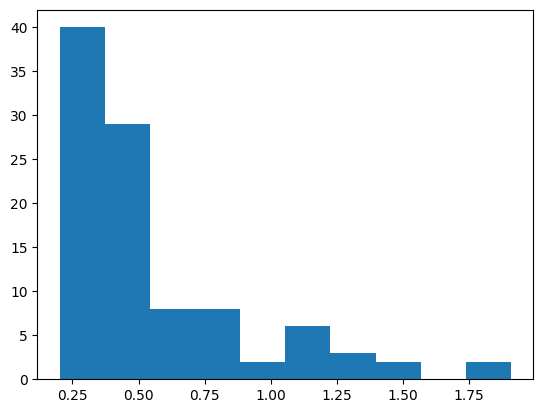

In [234]:
plt.hist(rho_ests)
plt.show()

### Study for varying knsparse and blur sigma

In [244]:
def vget_rho(blur_sigmas, knsparses, n_samples=200):

    output_rhos = np.zeros_like(blur_sigmas)
    p, q = blur_sigmas.shape

    n = 100

    # Setup
    R, W = jlinops.first_order_derivative_1d(n, boundary="zero")
    _R = R.toarray()

    for i in progress_bar(range(p)):

        for j in range(q):

            blur_sigma = blur_sigmas[i,j]
            knsparse = knsparses[i,j]
            R = np.sqrt(reg_lambda)*_R

            F = jlinops.Gaussian1DBlurOperator(n, blur_sigma=blur_sigma)
            F = jlinops.black_box_to_dense(F)

            rho_ests = []
            for k in range(n_samples):
                theta = rand_sparse_vector(n=n, num_nsparse=knsparse, sparse_low=1e-2, sparse_high=1e-1, nsparse_low=1e0, nsparse_high=1e0)

                R = np.diag(1.0/np.sqrt(theta)) @ _R # put in the weights 


                # Get spectrum of original problem
                Q1 = (F.T @ F) + (R.T @ R)
                Q1_eigvals = np.real(np.flip(np.sort(np.linalg.eigvals(Q1))))
                Q1_cond = np.linalg.cond(Q1)
                Q1_conds.append(Q1_cond)

                # Get spectrum for transformed problem
                Rpinv = np.linalg.pinv(R)
                Q2 = np.eye(R.shape[0]) + (Rpinv.T @ F.T @ F @ Rpinv)
                Q2_eigvals = np.real(np.flip(np.sort(np.linalg.eigvals(Q2))))
                Q2_cond = np.linalg.cond(Q2)
                Q2_conds.append(Q2_cond)

                # Improvement factor
                rho = Q1_cond/Q2_cond
                rho_ests.append(rho)

            mean_rho = np.mean(rho_ests)
            output_rhos[i,j] = mean_rho

            # print("finished one")
            

    return output_rhos

In [245]:
# Define the range and grid density for the parameters
# x =  np.float64(np.arange(start=1, stop=100, step=3)) # blur
# y =  np.arange(start=0, stop=100, step=5) # number of nonsparse components

x =  np.float64(np.arange(start=1, stop=100, step=10)) # blur
y =  np.arange(start=0, stop=100, step=15) # number of nonsparse components



# Create a meshgrid for the parameters
X, Y = np.meshgrid(x, y)

# Compute the function values
Z = vget_rho(X, Y)

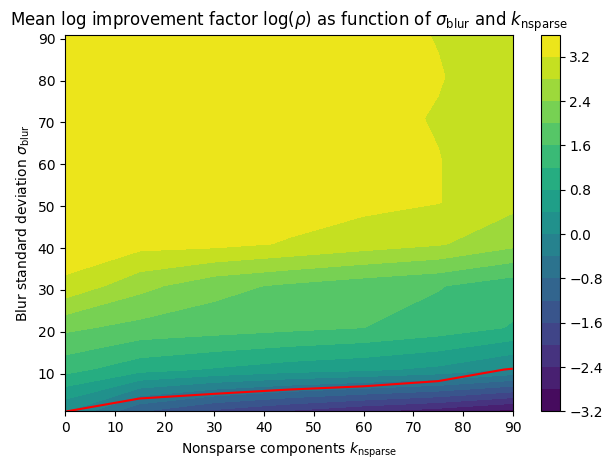

In [246]:
# Create the heatmap
plt.contourf(Y, X, np.log(Z), 20, cmap='viridis')
# Add a color bar to show the scale
plt.colorbar()

plt.contour(Y, X, Z, levels=[1.0], colors='red')



# Add labels and title if desired
plt.xlabel('Nonsparse components $k_{\\text{nsparse}}$')
plt.ylabel('Blur standard deviation $\sigma_{\\text{blur}}$')
plt.title('Mean log improvement factor $\log(\\rho)$ as function of $\sigma_{\\text{blur}}$ and $k_{\\text{nsparse}}$')
plt.tight_layout()
plt.savefig("sparsity_deblurring_gradient_conditioning.png", dpi=250, bbox_inches="tight")
plt.savefig("sparsity_deblurring_gradient_conditioning.eps", bbox_inches="tight")
# Show the plot
plt.show()

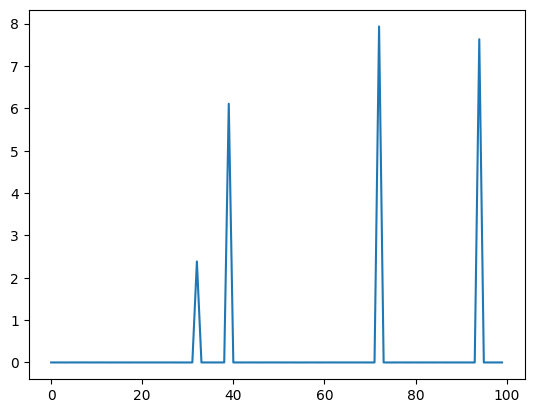

In [249]:
theta = rand_sparse_vector(100, 4)
plt.plot(theta)
plt.show()

In [ ]:
def rand_sparse_vector(n=50, num_nsparse=10, sparse_low=1e-4, sparse_high=1e-3, nsparse_low=1e-1, nsparse_high=1e1):
    """
    Generates a random vector of length n, where num_nsparse components are `non-sparse`. 
    The `sparse` and `non-sparse` components are drawn from uniform distributions as specified.
    """
    assert num_nsparse < n, "num_nsparse must be less than n."
    result = np.random.uniform(low=sparse_low, high=sparse_high, size=n)
    nsparse_idxs = np.random.choice( [i for i in range(n)], size=num_nsparse, replace=False )
    result[nsparse_idxs] = np.random.uniform(low=nsparse_low, high=nsparse_high, size=num_nsparse)
    return result

# Again

In [374]:
def rand_theta(n, num_nsparse, eps=1e-1, reg_lambda=1.0):
    assert num_nsparse <= n, "num_nsparse must be less than or equal to n."

    if num_nsparse < n:
        result = eps*np.ones(n)
        nsparse_idxs = np.random.choice( [i for i in range(n)], size=num_nsparse, replace=False )
        result[nsparse_idxs] = np.ones(num_nsparse)
        result = result/reg_lambda
    else:
        result = np.ones(num_nsparse)

    return result

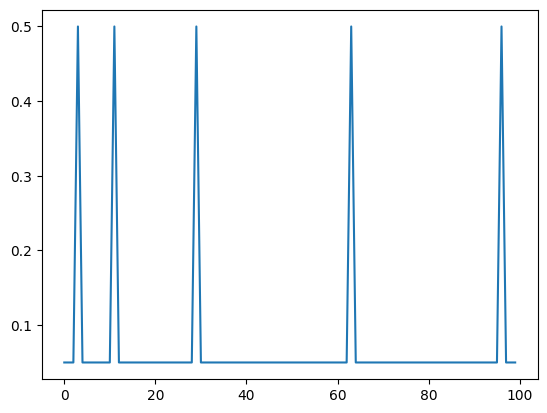

In [267]:
theta = rand_theta(100, 5, eps=1e-1, reg_lambda=2.0)
plt.plot(theta)
plt.show()

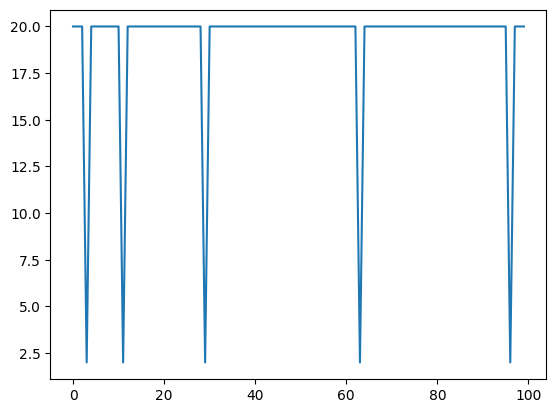

In [268]:
plt.plot(1.0/theta)
plt.show()

### Look at distribution

In [307]:
n = 100
knsparse = 5
blur_sigma = 4
n_samples = int(1e2)

reg_lambda = 1e1
eps = 1e-2

# Setup
F = jlinops.Gaussian1DBlurOperator(n, blur_sigma=blur_sigma)
F = jlinops.black_box_to_dense(F)
R, W = jlinops.first_order_derivative_1d(n, boundary="zero")
_R = R.toarray()


rho_ests = []
Q1_conds = []
Q2_conds = []
for j in progress_bar(range(n_samples)):

    theta = rand_theta(n, knsparse, eps, reg_lambda=reg_lambda)

    R = np.diag(1.0/np.sqrt(theta)) @ _R # put in the weights 


    # Get spectrum of original problem
    Q1 = (F.T @ F) + (R.T @ R)
    Q1_eigvals = np.real(np.flip(np.sort(np.linalg.eigvals(Q1))))
    Q1_cond = np.linalg.cond(Q1)
    Q1_conds.append(Q1_cond)

    # Get spectrum for transformed problem
    Rpinv = np.linalg.pinv(R)
    Q2 = np.eye(R.shape[0]) + (Rpinv.T @ F.T @ F @ Rpinv)
    Q2_eigvals = np.real(np.flip(np.sort(np.linalg.eigvals(Q2))))
    Q2_cond = np.linalg.cond(Q2)
    Q2_conds.append(Q2_cond)

    # Improvement factor
    rho = Q1_cond/Q2_cond

    rho_ests.append(rho)

rho_ests = np.asarray(rho_ests)


In [308]:
# eigvals, eigvecs = np.linalg.eigh(Q2)
eigvals, eigvecs = np.linalg.eigh( Rpinv.T @ F.T @ F @ Rpinv )

In [309]:
eigvecs[:,0]

array([ 0.        ,  0.003538  , -0.03146393,  0.06773138, -0.0728138 ,
        0.05809041, -0.05696952,  0.0547956 , -0.02501394, -0.00118704,
        0.02505658, -0.01676689, -0.00805802,  0.05754294, -0.11875445,
        0.16190618, -0.17593879,  0.15609805, -0.09054781, -0.00035123,
        0.08516005, -0.14739546,  0.20309752, -0.23103643,  0.20970628,
       -0.16194799,  0.10787426, -0.04122437, -0.01672123,  0.02665002,
       -0.00253154, -0.00906144,  0.00151656,  0.00671602, -0.01433711,
        0.01509657,  0.00752877, -0.0381857 ,  0.04776158, -0.04951612,
        0.06633426, -0.07300695,  0.04219799,  0.00179921, -0.03154966,
        0.05233273, -0.05672187,  0.01998269,  0.0496548 , -0.12313275,
        0.19024582, -0.23645091,  0.23186799, -0.17895696,  0.11136887,
       -0.03844355, -0.04559969,  0.11710902, -0.14964076,  0.14974408,
       -0.12419951,  0.06886623, -0.01224765, -0.00467546, -0.00047138,
        0.00185242,  0.00874934, -0.01157896,  0.0222033 , -0.03

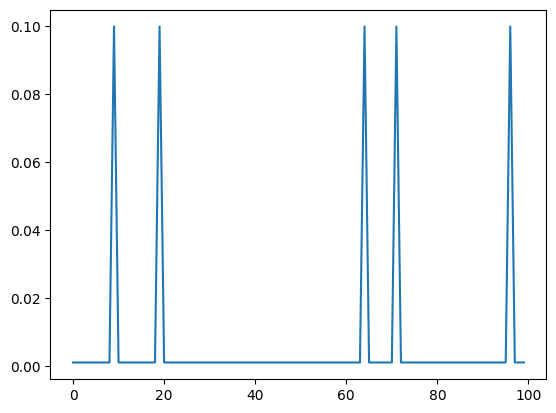

In [310]:
plt.plot(theta)

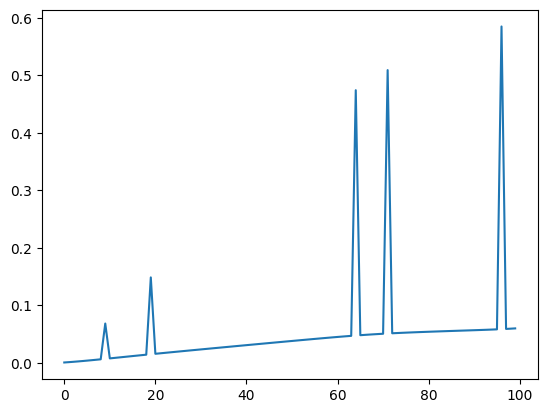

In [311]:
plt.plot(eigvecs[:,-1])
plt.show()

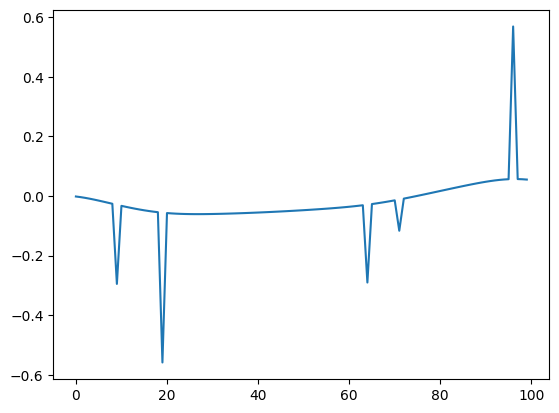

In [312]:
plt.plot(eigvecs[:,-2])
plt.show()

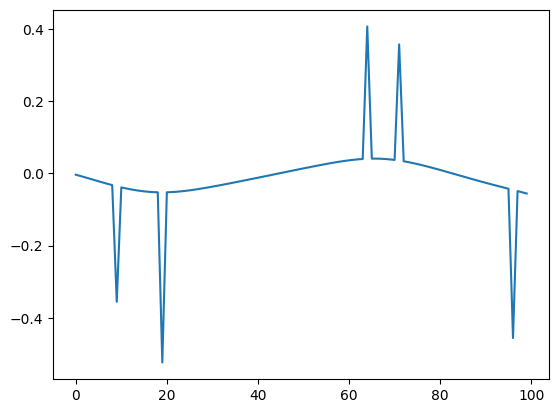

In [313]:
plt.plot(eigvecs[:,-3])
plt.show()

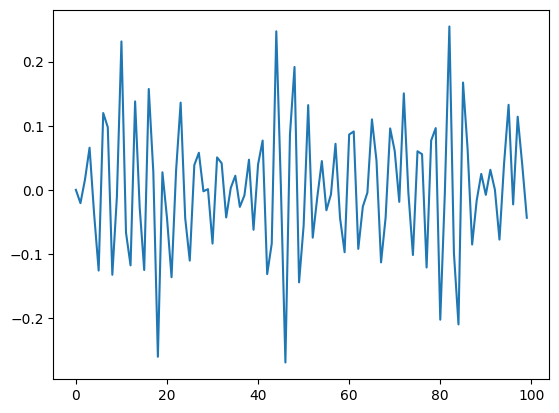

In [314]:
plt.plot(eigvecs[:,-50])
plt.show()

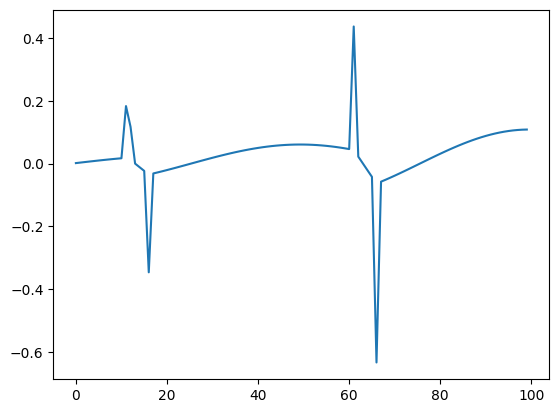

In [305]:
plt.plot(eigvecs[:,-5])
plt.show()

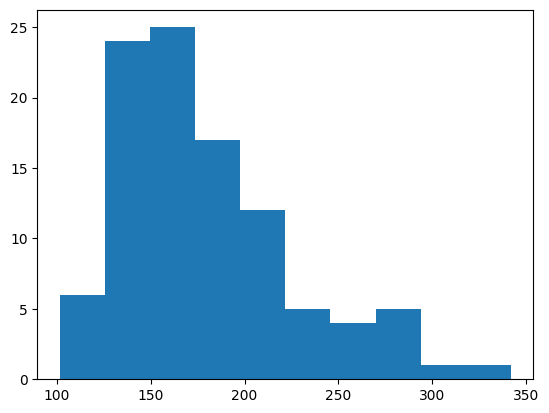

In [276]:
plt.hist(rho_ests)
plt.show()

# Vary nsparse and reg_lambda

In [370]:
def vget_rho(reg_lambdas, knsparses, n_samples=200, eps=1e-1, reg_lambda=1e0, blur_sigma=4.0):

    output_rhos = np.zeros_like(reg_lambdas)
    p, q = reg_lambdas.shape

    n = 100


    # Setup
    R, W = jlinops.first_order_derivative_1d(n, boundary="zero")
    _R = R.toarray()

    F = jlinops.Gaussian1DBlurOperator(n, blur_sigma=blur_sigma)
    F = jlinops.black_box_to_dense(F)

    for i in progress_bar(range(p)):

        for j in range(q):

            reg_lambda = reg_lambdas[i,j]
            knsparse = knsparses[i,j]
          
            rho_ests = []
            for k in range(n_samples):

                theta = rand_theta(n, num_nsparse=knsparse, eps=eps, reg_lambda=reg_lambda)
                
                R = np.diag(1.0/np.sqrt(theta)) @ _R # put in the weights 

                # Get spectrum of original problem
                Q1 = (F.T @ F) + (R.T @ R)
                Q1_eigvals = np.real(np.flip(np.sort(np.linalg.eigvals(Q1))))
                Q1_cond = np.linalg.cond(Q1)
                Q1_conds.append(Q1_cond)

                # Get spectrum for transformed problem
                Rpinv = np.linalg.pinv(R)
                Q2 = np.eye(R.shape[0]) + (Rpinv.T @ F.T @ F @ Rpinv)
                Q2_eigvals = np.real(np.flip(np.sort(np.linalg.eigvals(Q2))))
                Q2_cond = np.linalg.cond(Q2)
                Q2_conds.append(Q2_cond)

                # Improvement factor
                rho = Q1_cond/Q2_cond
                rho_ests.append(rho)

            mean_rho = np.mean(rho_ests)
            output_rhos[i,j] = mean_rho

            # print("finished one")
            

    return output_rhos

In [375]:
rand_theta(100, 100)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [377]:
# Define the range and grid density for the parameters
# x =  np.float64(np.arange(start=1, stop=100, step=3)) # blur
# y =  np.arange(start=0, stop=100, step=5) # number of nonsparse components

x = np.logspace(-2, 3, num=20) # reg_lambdas
y =  np.arange(start=0, stop=100, step=1) # number of nonsparse components

# Create a meshgrid for the parameters
X, Y = np.meshgrid(x, y)

# Compute the function values
Z = vget_rho(X, Y, n_samples=100, eps=1e-2, blur_sigma=4)

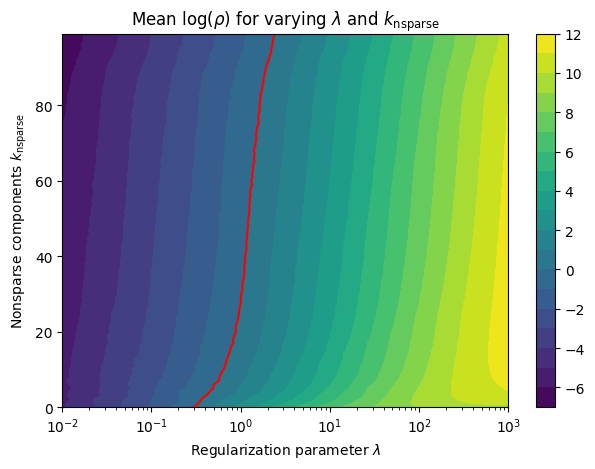

In [378]:
# Create the heatmap
plt.contourf(X, Y, np.log(Z), 20, cmap='viridis')
# Add a color bar to show the scale
plt.colorbar()

plt.contour(X, Y, np.log(Z), levels=[0.0], colors='red')
plt.xscale("log")


# Add labels and title if desired
plt.xlabel('Regularization parameter $\lambda$')
plt.ylabel('Nonsparse components $k_{\\text{nsparse}}$')
plt.title('Mean $\log(\\rho)$ for varying $\lambda$ and $k_{\\text{nsparse}}$')
plt.tight_layout()
plt.savefig("sparsity_deblurring_gradient_conditioning_varying_reg_nsparse.png", dpi=250, bbox_inches="tight")
plt.savefig("sparsity_deblurring_gradient_conditioning_varying_reg_nsparse.eps", bbox_inches="tight")
# Show the plot
plt.show()

In [ ]:
# epsilon = 1e-2
# blur = 4

# Again

In [380]:
# Define the range and grid density for the parameters
# x =  np.float64(np.arange(start=1, stop=100, step=3)) # blur
# y =  np.arange(start=0, stop=100, step=5) # number of nonsparse components

x = np.logspace(-2, 3, num=20) # reg_lambdas
y =  np.arange(start=0, stop=100, step=1) # number of nonsparse components

# Create a meshgrid for the parameters
X, Y = np.meshgrid(x, y)

# Compute the function values
Z = vget_rho(X, Y, n_samples=100, eps=1e-3, blur_sigma=4)

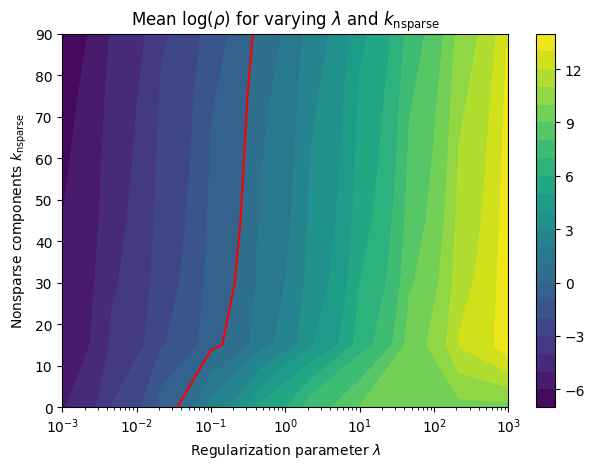

In [ ]:
# Create the heatmap
plt.contourf(X, Y, np.log(Z), 20, cmap='viridis')
# Add a color bar to show the scale
plt.colorbar()

plt.contour(X, Y, np.log(Z), levels=[0.0], colors='red')
plt.xscale("log")


# Add labels and title if desired
plt.xlabel('Regularization parameter $\lambda$')
plt.ylabel('Nonsparse components $k_{\\text{nsparse}}$')
plt.title('Mean $\log(\\rho)$ for varying $\lambda$ and $k_{\\text{nsparse}}$')
plt.tight_layout()
plt.savefig("sparsity_deblurring_gradient_conditioning_varying_reg_nsparse_second.png", dpi=250, bbox_inches="tight")
plt.savefig("sparsity_deblurring_gradient_conditioning_varying_reg_nsparse_second.eps", bbox_inches="tight")
# Show the plot
plt.show()

# ? 

In [382]:
def vget_rho(reg_lambdas, knsparses, n_samples=200, eps=1e-1, reg_lambda=1e0, blur_sigma=4.0):

    output_rhos = np.zeros_like(reg_lambdas)
    p, q = reg_lambdas.shape

    n = 100


    # # Setup
    # R, W = jlinops.first_order_derivative_1d(n, boundary="zero")
    # _R = R.toarray()

    # F = jlinops.Gaussian1DBlurOperator(n, blur_sigma=blur_sigma)
    # F = jlinops.black_box_to_dense(F)

    F = np.eye(n)
    _R = np.eye(n)

    for i in progress_bar(range(p)):

        for j in range(q):

            reg_lambda = reg_lambdas[i,j]
            knsparse = knsparses[i,j]
          
            rho_ests = []
            for k in range(n_samples):

                theta = rand_theta(n, num_nsparse=knsparse, eps=eps, reg_lambda=reg_lambda)
                
                R = np.diag(1.0/np.sqrt(theta)) @ _R.copy() # put in the weights 

                # Get spectrum of original problem
                Q1 = (F.T @ F) + (R.T @ R)
                Q1_eigvals = np.real(np.flip(np.sort(np.linalg.eigvals(Q1))))
                Q1_cond = np.linalg.cond(Q1)
                Q1_conds.append(Q1_cond)

                # Get spectrum for transformed problem
                Rpinv = np.linalg.pinv(R)
                Q2 = np.eye(R.shape[0]) + (Rpinv.T @ F.T @ F @ Rpinv)
                Q2_eigvals = np.real(np.flip(np.sort(np.linalg.eigvals(Q2))))
                Q2_cond = np.linalg.cond(Q2)
                Q2_conds.append(Q2_cond)

                # Improvement factor
                rho = Q1_cond/Q2_cond
                rho_ests.append(rho)

            mean_rho = np.mean(rho_ests)
            output_rhos[i,j] = mean_rho

            # print("finished one")
            

    return output_rhos

In [387]:
# Define the range and grid density for the parameters
# x =  np.float64(np.arange(start=1, stop=100, step=3)) # blur
# y =  np.arange(start=0, stop=100, step=5) # number of nonsparse components

x = np.logspace(-4, 3, num=20) # reg_lambdas
y =  np.arange(start=0, stop=101, step=1) # number of nonsparse components

# Create a meshgrid for the parameters
X, Y = np.meshgrid(x, y)

In [388]:
# Compute the function values
Z = vget_rho(X, Y, n_samples=100, eps=1e-2)

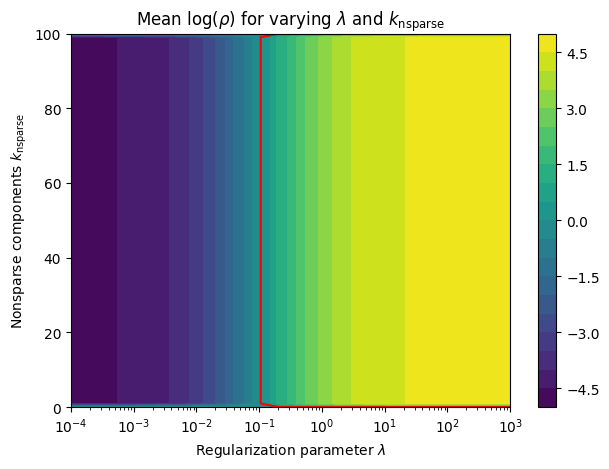

In [389]:
# Create the heatmap
plt.contourf(X, Y, np.log(Z), 20, cmap='viridis')
# Add a color bar to show the scale
plt.colorbar()

plt.contour(X, Y, np.log(Z), levels=[0.0], colors='red')
plt.xscale("log")


# Add labels and title if desired
plt.xlabel('Regularization parameter $\lambda$')
plt.ylabel('Nonsparse components $k_{\\text{nsparse}}$')
plt.title('Mean $\log(\\rho)$ for varying $\lambda$ and $k_{\\text{nsparse}}$')
plt.tight_layout()
plt.savefig("sparsity_identity_conditioning_varying_reg_nsparse.png", dpi=250, bbox_inches="tight")
plt.savefig("sparsity_identity_conditioning_varying_reg_nsparse.eps", bbox_inches="tight")
# Show the plot
plt.show()

# With identity forward operator and regularization

In [353]:
n = 100
reg_lambda = 1e2
knsparses = np.asarray([ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 40, 50, 60] )
n_samples = 3

F = np.eye(n)
R = np.eye(n)

output_rhos = []
output_log_rhos = []

for i, knsparse in enumerate(knsparses):


    rho_ests = []
    log_rho_ests = []
    for k in range(n_samples):

        theta = rand_theta(n, num_nsparse=knsparse, eps=eps, reg_lambda=reg_lambda)
        
        R = np.diag(1.0/np.sqrt(theta)) # put in the weights 

        # Get spectrum of original problem
        #Q1 = (F.T @ F) + (R.T @ R)
        Q1 = np.diag(1.0/theta)
        Q1_eigvals = np.real(np.flip(np.sort(np.linalg.eigvals(Q1))))
        Q1_cond = np.linalg.cond(Q1)
        #print(Q1_cond)
        Q1_conds.append(Q1_cond)

        # Get spectrum for transformed problem
        #Rpinv = np.diag(np.sqrt(theta))
        Q2 = np.eye(R.shape[0]) + (Rpinv.T @ F.T @ F @ Rpinv)
        Q2 = np.diag(theta)
        Q2_eigvals = np.real(np.flip(np.sort(np.linalg.eigvals(Q2))))
        Q2_cond = np.linalg.cond(Q2)
        #print(Q2_cond)
        Q2_conds.append(Q2_cond)

        # Improvement factor
        rho = Q1_cond/Q2_cond
        log_rho = np.log(Q1_cond) - np.log(Q2_cond)
        rho_ests.append(rho)
        log_rho_ests.append(log_rho)

    mean_rho = np.mean(rho_ests)
    mean_log_rho = np.mean(log_rho_ests)

    output_rhos.append(mean_rho)
    output_log_rhos.append(mean_log_rho)



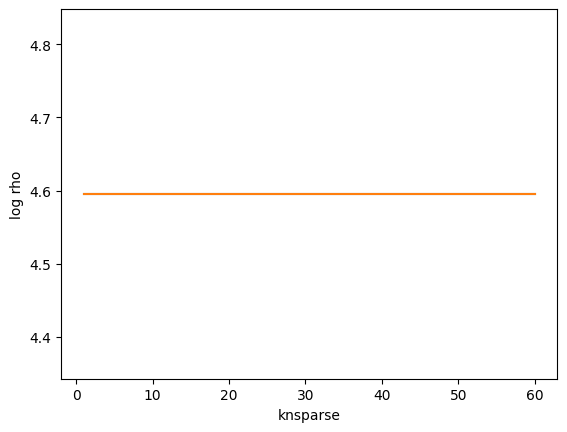

In [354]:
plt.plot(knsparses, np.log(output_rhos))
plt.plot(knsparses, output_log_rhos)
plt.xlabel("knsparse")
plt.ylabel("log rho")
plt.show()

In [366]:
def vget_rho(reg_lambdas, knsparses, n_samples=200, eps=1e-1, reg_lambda=1e0):

    output_rhos = np.zeros_like(reg_lambdas)
    p, q = reg_lambdas.shape

    n = 30

    F = np.eye(n)
    R = np.eye(n)

    for i in progress_bar(range(p)):

        for j in range(q):

            reg_lambda = reg_lambdas[i,j]
            knsparse = knsparses[i,j]
          
            rho_ests = []
            for k in range(n_samples):

                theta = rand_theta(n, num_nsparse=knsparse, eps=eps, reg_lambda=reg_lambda)
                
                #R = np.diag(1.0/np.sqrt(theta)) @ _R # put in the weights 

                # Get spectrum of original problem
                #Q1 = (F.T @ F) + (R.T @ R)
                Q1 = np.eye(n) + np.diag(1.0/theta)
                Q1_eigvals = np.real(np.flip(np.sort(np.linalg.eigvals(Q1))))
                Q1_cond = np.linalg.cond(Q1)
                Q1_conds.append(Q1_cond)

                # Get spectrum for transformed problem
                #Rpinv = np.diag(np.sqrt(theta))
                #Q2 = np.eye(R.shape[0]) + (Rpinv.T @ F.T @ F @ Rpinv)
                Q2 = np.eye(n) + np.diag(theta)
                Q2_eigvals = np.real(np.flip(np.sort(np.linalg.eigvals(Q2))))
                Q2_cond = np.linalg.cond(Q2)
                Q2_conds.append(Q2_cond)

                # Improvement factor
                rho = Q1_cond/Q2_cond
                rho_ests.append(rho)

            mean_rho = np.mean(rho_ests)
            output_rhos[i,j] = mean_rho

            # print("finished one")
            

    return output_rhos

In [368]:
# Define the range and grid density for the parameters
# x =  np.float64(np.arange(start=1, stop=100, step=3)) # blur
# y =  np.arange(start=0, stop=100, step=5) # number of nonsparse components

x = np.logspace(-4, 3, num=10) # reg_lambdas
y =  np.arange(start=0, stop=100, step=) # number of nonsparse components

# Create a meshgrid for the parameters
X, Y = np.meshgrid(x, y)

# Compute the function values
Z = vget_rho(X, Y, n_samples=500, eps=1e-2)

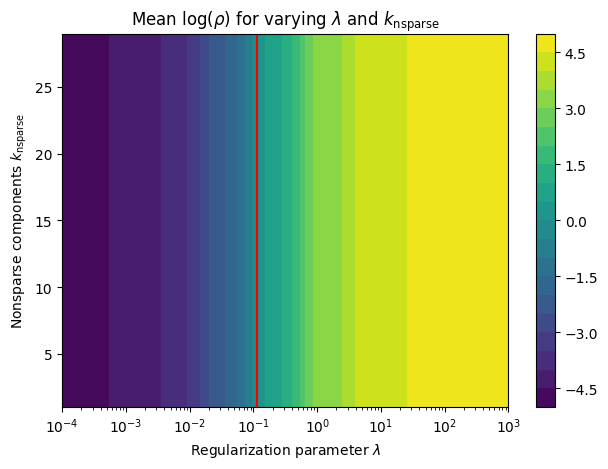

In [369]:
# Create the heatmap
plt.contourf(X, Y, np.log(Z), 20, cmap='viridis')
# Add a color bar to show the scale
plt.colorbar()

plt.contour(X, Y, np.log(Z), levels=[0.0], colors='red')
plt.xscale("log")


# Add labels and title if desired
plt.xlabel('Regularization parameter $\lambda$')
plt.ylabel('Nonsparse components $k_{\\text{nsparse}}$')
plt.title('Mean $\log(\\rho)$ for varying $\lambda$ and $k_{\\text{nsparse}}$')
plt.tight_layout()
plt.savefig("sparsity_identity_conditioning_varying_reg_nsparse.png", dpi=250, bbox_inches="tight")
plt.savefig("sparsity_identity_conditioning_varying_reg_nsparse.eps", bbox_inches="tight")
# Show the plot
plt.show()

In [390]:
# Define the range and grid density for the parameters
# x =  np.float64(np.arange(start=1, stop=100, step=3)) # blur
# y =  np.arange(start=0, stop=100, step=5) # number of nonsparse components


x = np.logspace(-4, 3, num=20) # reg_lambdas
y =  np.arange(start=0, stop=101, step=1) # number of nonsparse components


# Create a meshgrid for the parameters
X, Y = np.meshgrid(x, y)

# Compute the function values
Z = vget_rho(X, Y, n_samples=100, eps=1e-3)

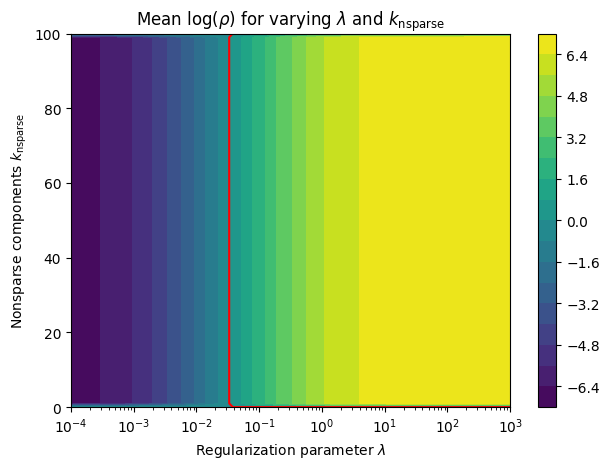

In [392]:
# Create the heatmap
plt.contourf(X, Y, np.log(Z), 20, cmap='viridis')
# Add a color bar to show the scale
plt.colorbar()

plt.contour(X, Y, np.log(Z), levels=[0.0], colors='red')
plt.xscale("log")


# Add labels and title if desired
plt.xlabel('Regularization parameter $\lambda$')
plt.ylabel('Nonsparse components $k_{\\text{nsparse}}$')
plt.title('Mean $\log(\\rho)$ for varying $\lambda$ and $k_{\\text{nsparse}}$')
plt.tight_layout()
plt.savefig("sparsity_identity_conditioning_varying_reg_nsparse_second.png", dpi=250, bbox_inches="tight")
plt.savefig("sparsity_identity_conditioning_varying_reg_nsparse_second.eps", bbox_inches="tight")
# Show the plot
plt.show()

# With random forward operator and regularization operator

In [401]:
def vget_rho(reg_lambdas, knsparses, n_samples=200, eps=1e-1, reg_lambda=1e0, m=50, k=120, n=100):

    output_rhos = np.zeros_like(reg_lambdas)
    p, q = reg_lambdas.shape

    for i in progress_bar(range(p)):

        for j in range(q):

            reg_lambda = reg_lambdas[i,j]
            knsparse = knsparses[i,j]
          
            rho_ests = []
            for k in range(n_samples):

                theta = rand_theta(n, num_nsparse=knsparse, eps=eps, reg_lambda=reg_lambda)
                F = np.random.normal(size=(m,n))
                R = np.random.normal(size=(k,n))
                R = np.diag(1.0/np.sqrt(theta)) @ _R # put in the weights 

                # Get spectrum of original problem
                Q1 = (F.T @ F) + (R.T @ R)
                Q1_cond = np.linalg.cond(Q1)
                Q1_conds.append(Q1_cond)

                # Get spectrum for transformed problem
                Rpinv = np.linalg.pinv( R )
                Q2 = np.eye(R.shape[0]) + (Rpinv.T @ F.T @ F @ Rpinv)
                Q2_cond = np.linalg.cond(Q2)
                Q2_conds.append(Q2_cond)

                # Improvement factor
                rho = Q1_cond/Q2_cond
                rho_ests.append(rho)

            mean_rho = np.mean(rho_ests)
            output_rhos[i,j] = mean_rho

            # print("finished one")
            

    return output_rhos

In [404]:
x = np.logspace(-4, 3, num=20) # reg_lambdas
y = np.arange(start=0, stop=100, step=1) # number of nonsparse components

# Create a meshgrid for the parameters
X, Y = np.meshgrid(x, y)

# Compute the function values
Z = vget_rho(X, Y, n_samples=100, eps=1e-2)

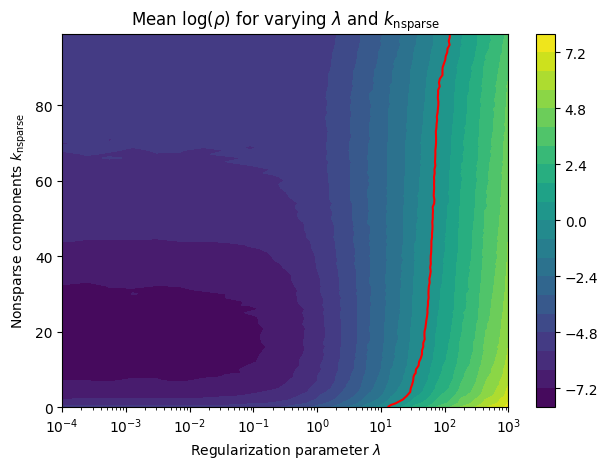

In [407]:
# Create the heatmap
plt.contourf(X, Y, np.log(Z), 20, cmap='viridis')
# Add a color bar to show the scale
plt.colorbar()

plt.contour(X, Y, np.log(Z), levels=[0.0], colors='red')
plt.xscale("log")


# Add labels and title if desired
plt.xlabel('Regularization parameter $\lambda$')
plt.ylabel('Nonsparse components $k_{\\text{nsparse}}$')
plt.title('Mean $\log(\\rho)$ for varying $\lambda$ and $k_{\\text{nsparse}}$')
plt.tight_layout()
plt.savefig("random_conditioning_varying_reg_nsparse.png", dpi=250, bbox_inches="tight")
plt.savefig("random_conditioning_varying_reg_nsparse.eps", bbox_inches="tight")
# Show the plot
plt.show()